# Sentiment Analysis for Predicting Consumer Disputes Using ML Classification Algorithms

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import plotly.express as px 

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
import string
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.svm import SVC 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import BinaryEncoder
from imblearn.combine import SMOTETomek

from hyperopt import tpe,hp,Trials,space_eval
from hyperopt.fmin import fmin
from hyperopt.pyll import scope 

plt.style.use('seaborn-v0_8-darkgrid')
import warnings
warnings.filterwarnings('ignore') 
pd.pandas.set_option('display.max_columns', None) 

In [2]:
data = pd.read_csv('consumer_complaints.csv') 
data.head() 

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [3]:
data.shape 

(555957, 18)

In [4]:
target = 'consumer_disputed?'

data[target].value_counts() 

consumer_disputed?
No     443823
Yes    112134
Name: count, dtype: int64

In [5]:
data[target].value_counts(normalize=True)*100 

consumer_disputed?
No     79.830455
Yes    20.169545
Name: proportion, dtype: float64

In [6]:
data.isna().sum() 

date_received                        0
product                              0
sub_product                     158322
issue                                0
sub_issue                       343335
consumer_complaint_narrative    489151
company_public_response         470833
company                              0
state                             4887
zipcode                           4505
tags                            477998
consumer_consent_provided       432499
submitted_via                        0
date_sent_to_company                 0
company_response_to_consumer         0
timely_response                      0
consumer_disputed?                   0
complaint_id                         0
dtype: int64

In [7]:
data.drop(columns=['sub_product','sub_issue','consumer_complaint_narrative','company_public_response','tags','zipcode', 'complaint_id', 'company'], axis=1, inplace=True) 

In [8]:
data.dtypes

date_received                   object
product                         object
issue                           object
state                           object
consumer_consent_provided       object
submitted_via                   object
date_sent_to_company            object
company_response_to_consumer    object
timely_response                 object
consumer_disputed?              object
dtype: object

In [9]:
for col in data.columns:
    print(col,' -- ', data[col].nunique()) 

date_received  --  1608
product  --  11
issue  --  95
state  --  62
consumer_consent_provided  --  4
submitted_via  --  6
date_sent_to_company  --  1557
company_response_to_consumer  --  8
timely_response  --  2
consumer_disputed?  --  2


## Visualizing Target column

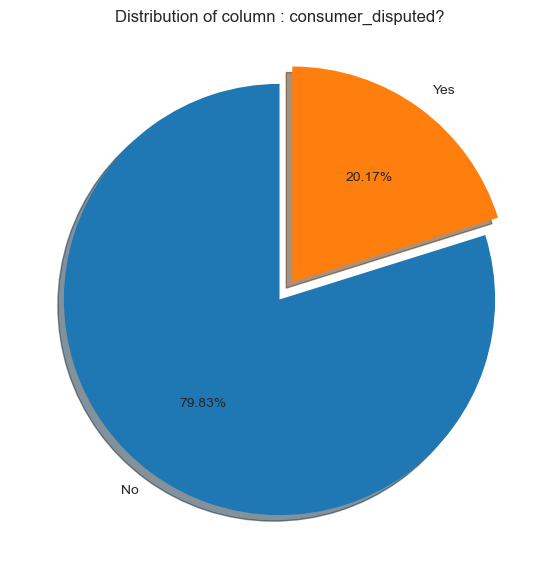

In [10]:
percentage = data[target].value_counts(normalize=True)*100
label=['No','Yes']

fig,ax = plt.subplots(figsize=(20,7)) 
explode = (0, 0.1) 
ax.pie(percentage, labels=label, startangle=90, explode=explode, shadow=True, autopct='%1.2f%%')
plt.title(f'Distribution of column : {target}')
plt.show() 

It is clear that the target variable is imbalanced

### Products on which complaints are made

In [11]:
product_percentage = data['product'].value_counts(normalize=True)*100
product_percentage.to_frame() 

,proportion
product,
Mortgage,33.541263
Debt collection,18.176226
Credit reporting,16.521781
Credit card,11.955601
Bank account or service,11.253208
Consumer Loan,3.775472
Student loan,2.848961
Payday loan,0.697356
Money transfers,0.685665


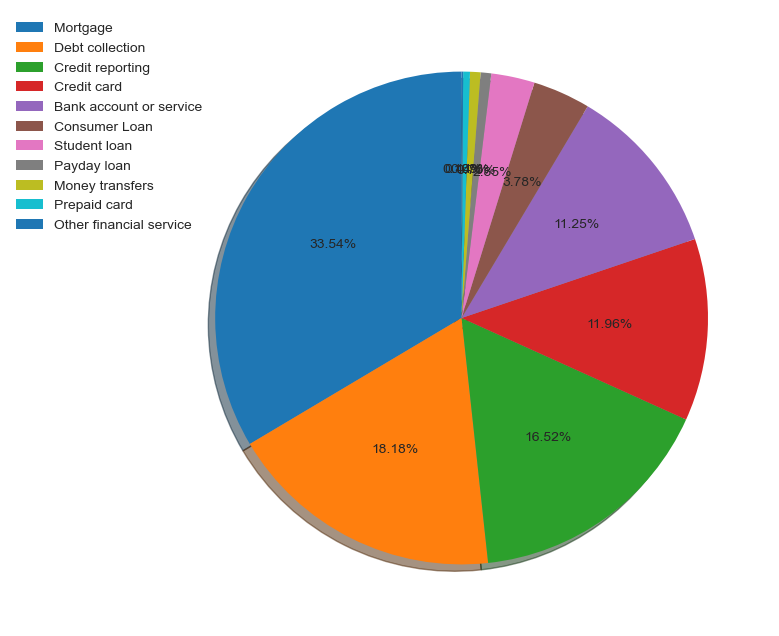

In [12]:
product_labels = product_percentage.index 

fig,ax = plt.subplots(figsize=(20,8)) 
explode = (0, 0.1) 

ax.pie(product_percentage, startangle=90, shadow=True, autopct='%1.2f%%')
plt.legend(loc='best', labels=product_labels, bbox_to_anchor=(0.1,1.0))
plt.show() 

### Company's Response and its effect on target feature

In [13]:
data.groupby('company_response_to_consumer')[target].value_counts(normalize=True)*100

company_response_to_consumer     consumer_disputed?
Closed                           No                     78.289425
                                 Yes                    21.710575
Closed with explanation          No                     77.620686
                                 Yes                    22.379314
Closed with monetary relief      No                     89.002143
                                 Yes                    10.997857
Closed with non-monetary relief  No                     87.226106
                                 Yes                    12.773894
Closed with relief               No                     86.540999
                                 Yes                    13.459001
Closed without relief            No                     72.913060
                                 Yes                    27.086940
In progress                      No                    100.000000
Untimely response                No                     99.928290
                        

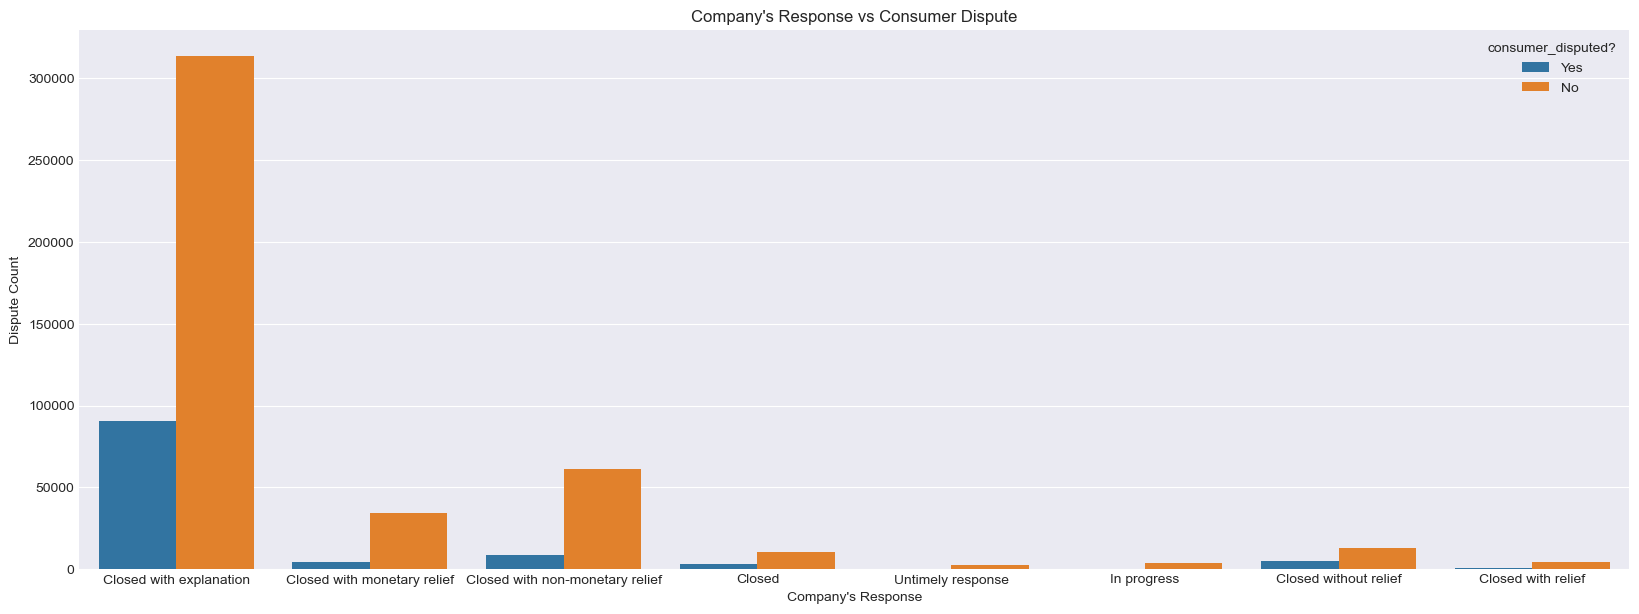

In [14]:
plt.subplots(figsize=(20,7)) 
sns.countplot(x='company_response_to_consumer', hue=target, data=data) 
plt.title("Company's Response vs Consumer Dispute")
plt.xlabel("Company's Response")
plt.ylabel('Dispute Count') 
plt.xticks(rotation=0) 
plt.show() 

### Finance Complaint Year and Disputed Consumer count

In [15]:
data['Received_data'] = pd.to_datetime(data['date_received']).dt.date
data['Received_month'] = pd.to_datetime(data['date_received']).dt.month
data['Received_year'] = pd.to_datetime(data['date_received']).dt.year 

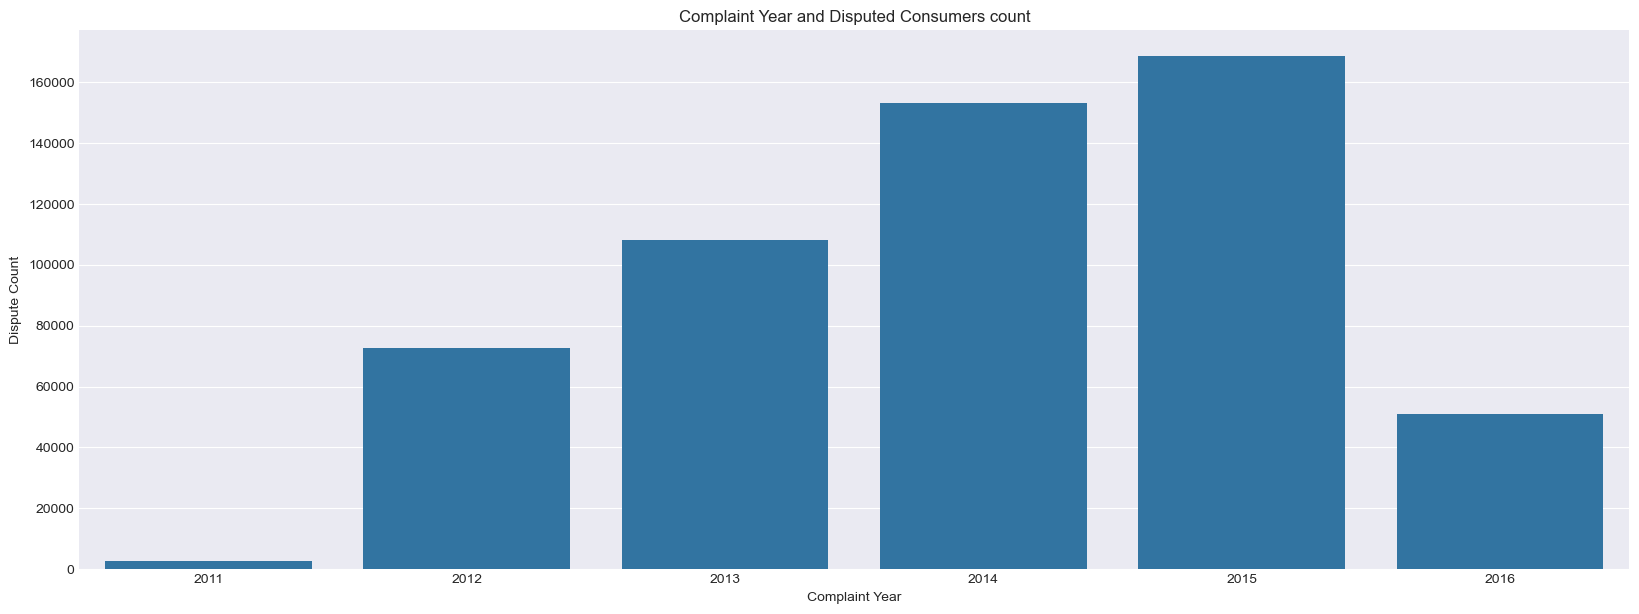

In [16]:
plt.subplots(figsize=(20,7)) 
sns.countplot(x='Received_year', data=data) 
plt.xticks(rotation=0) 
plt.title('Complaint Year and Disputed Consumers count') 
plt.xlabel('Complaint Year')
plt.ylabel('Dispute Count') 
plt.show() 

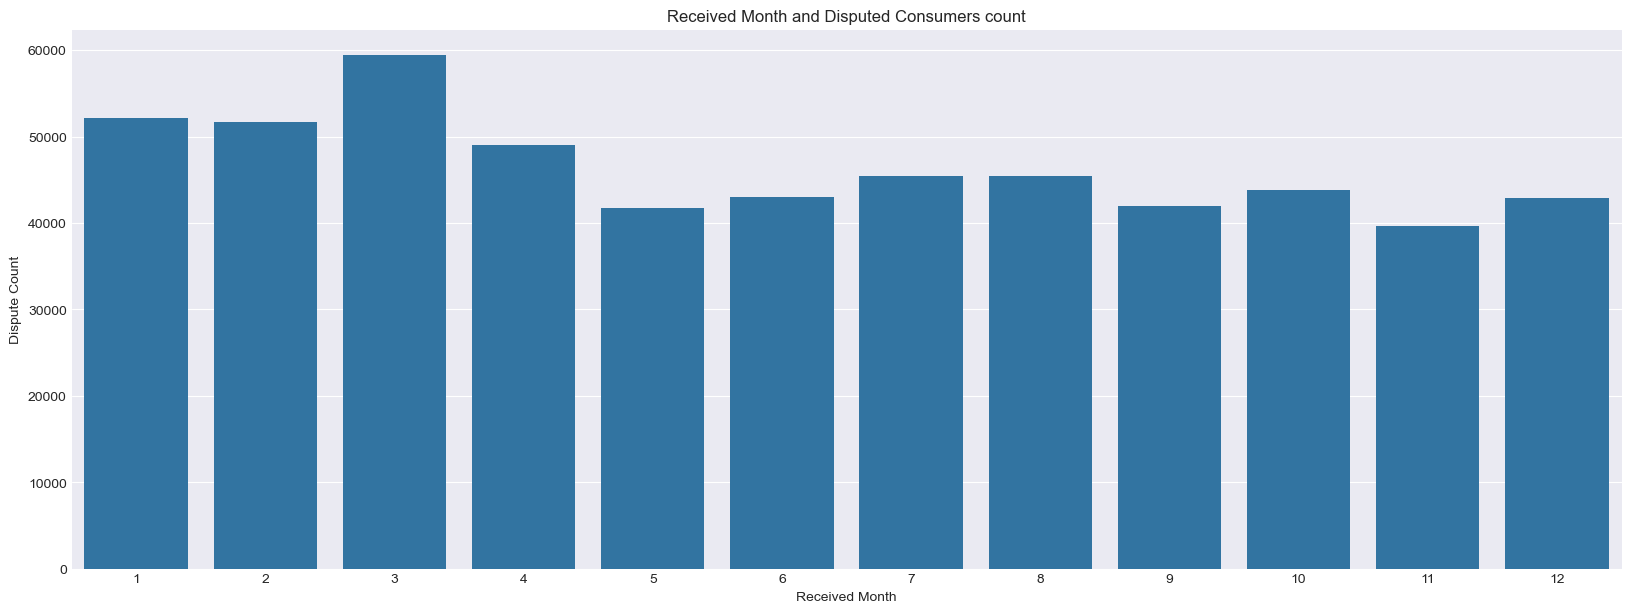

In [17]:
plt.subplots(figsize=(20,7)) 
sns.countplot(x='Received_month', data=data) 
plt.xticks(rotation=0) 
plt.title('Received Month and Disputed Consumers count') 
plt.xlabel('Received Month')
plt.ylabel('Dispute Count') 
plt.show() 

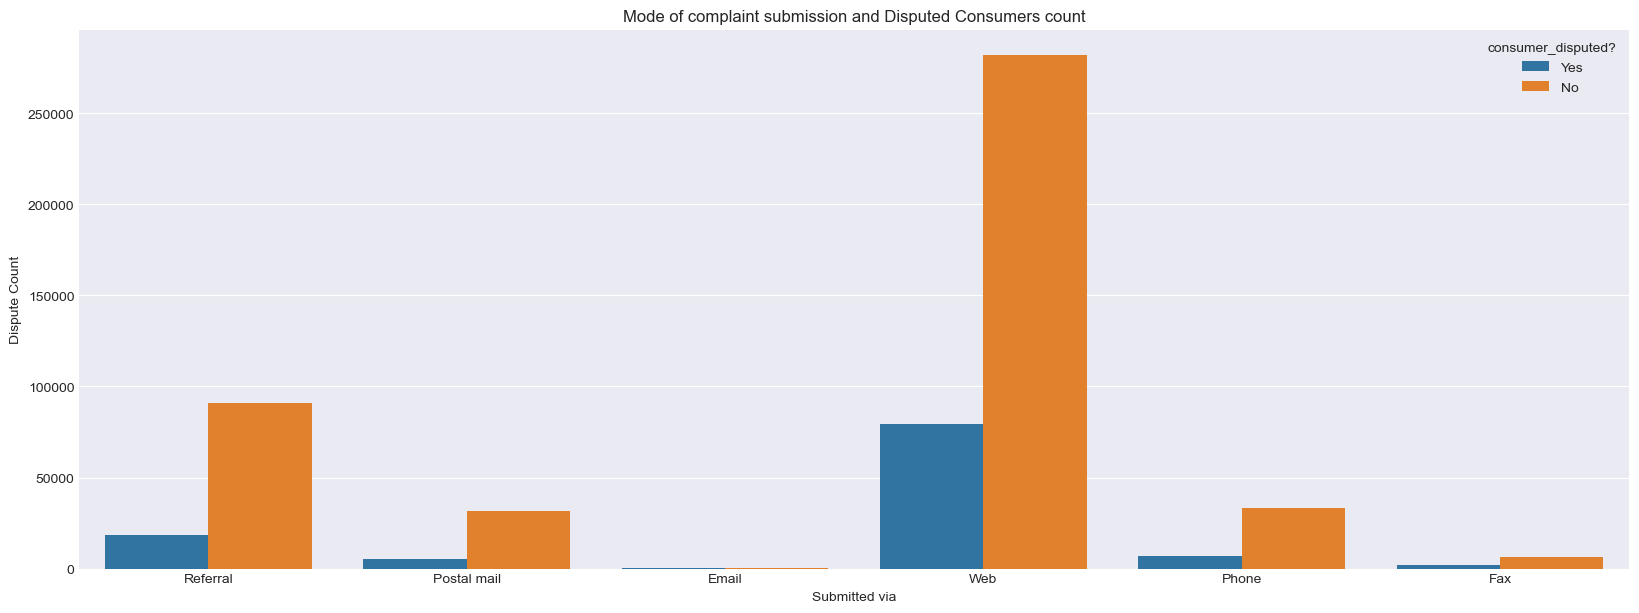

In [18]:
plt.subplots(figsize=(20,7)) 
sns.countplot(x='submitted_via', hue=target, data=data) 
plt.xticks(rotation=0) 
plt.title('Mode of complaint submission and Disputed Consumers count') 
plt.xlabel('Submitted via')
plt.ylabel('Dispute Count') 
plt.show() 

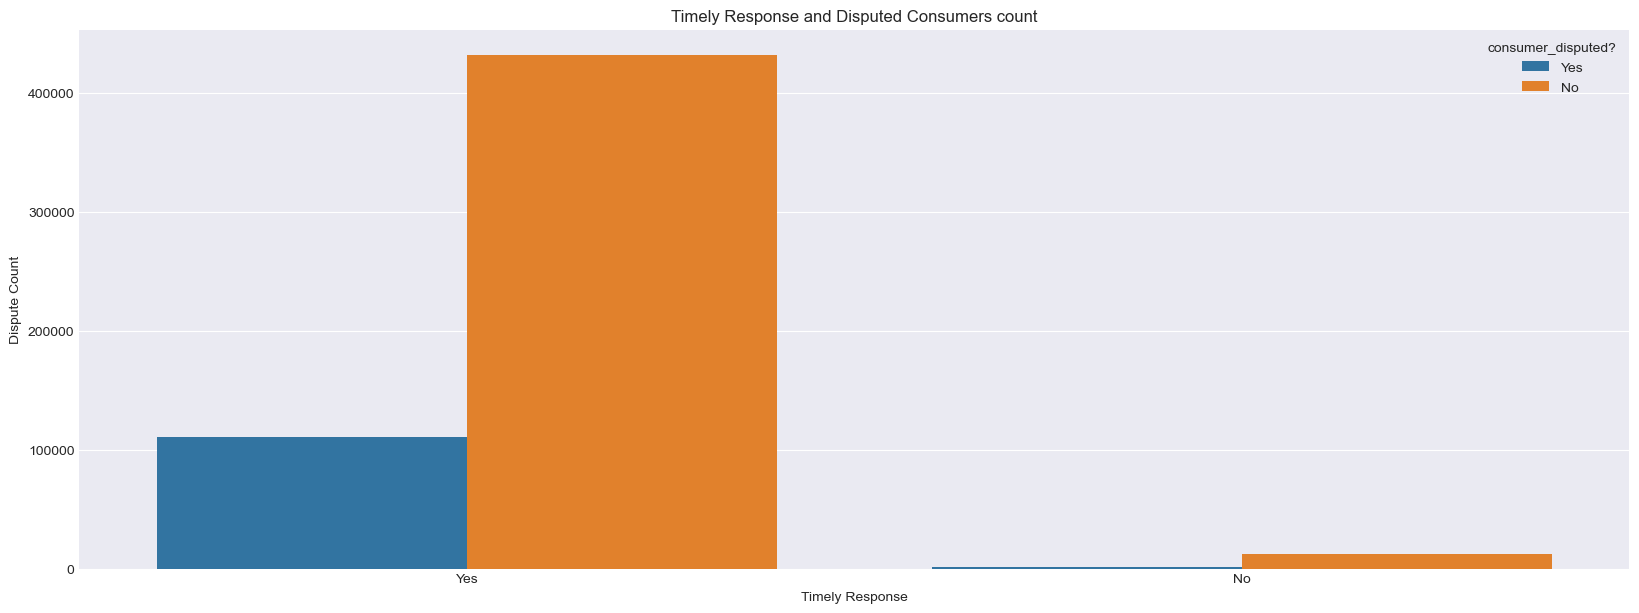

In [19]:
plt.subplots(figsize=(20,7)) 
sns.countplot(x='timely_response', hue=target, data=data) 
plt.xticks(rotation=0) 
plt.title('Timely Response and Disputed Consumers count') 
plt.xlabel('Timely Response')
plt.ylabel('Dispute Count') 
plt.show() 

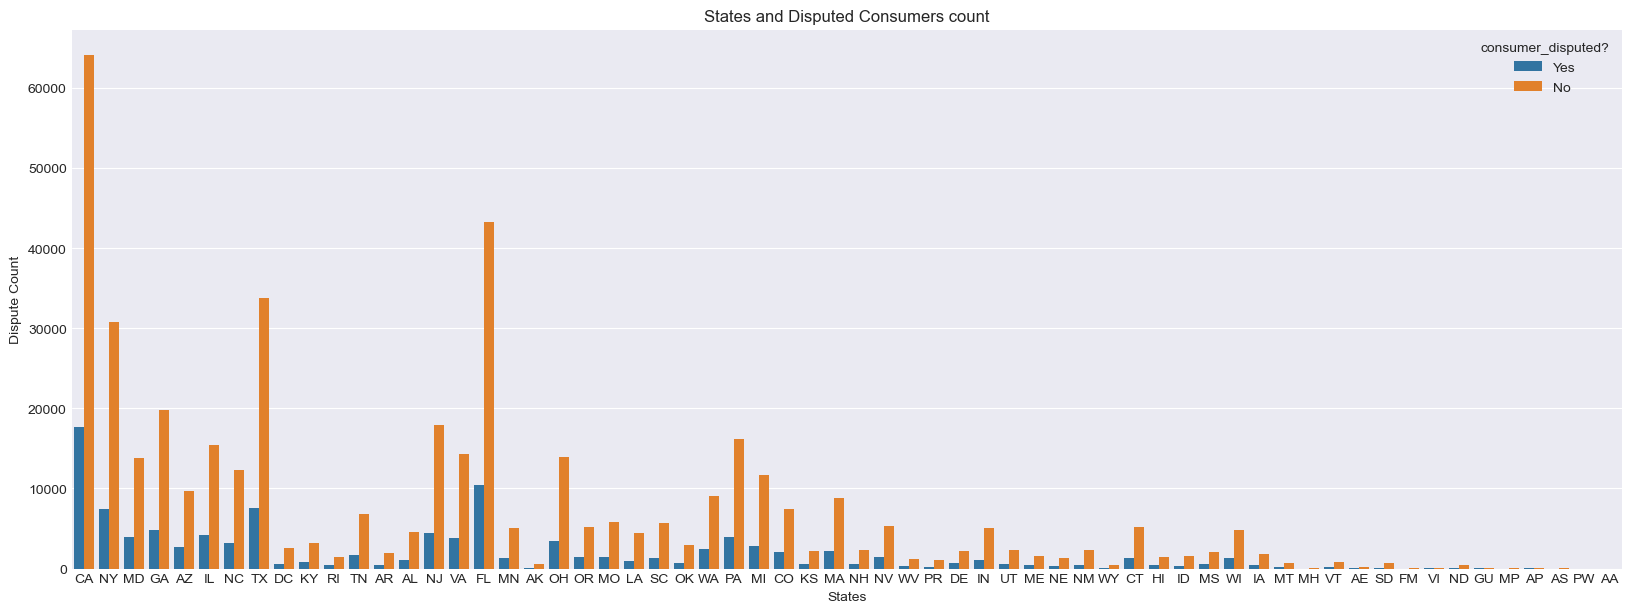

In [20]:
plt.subplots(figsize=(20,7)) 
sns.countplot(x='state', hue=target, data=data) 
plt.xticks(rotation=0) 
plt.title('States and Disputed Consumers count') 
plt.xlabel('States')
plt.ylabel('Dispute Count') 
plt.show() 

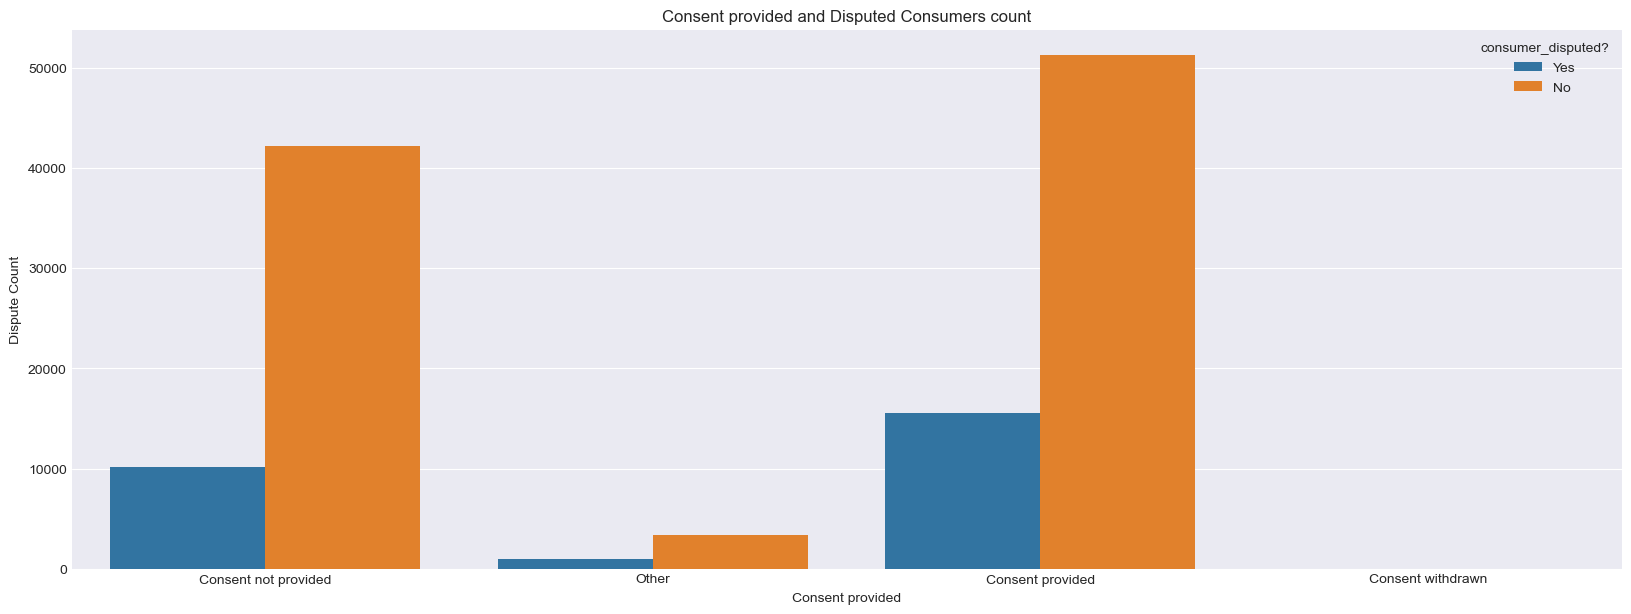

In [21]:
plt.subplots(figsize=(20,7)) 
sns.countplot(x='consumer_consent_provided', hue=target, data=data) 
plt.xticks(rotation=0) 
plt.title('Consent provided and Disputed Consumers count') 
plt.xlabel('Consent provided')
plt.ylabel('Dispute Count') 
plt.show() 

# Feature Engineering and Model Training

In [22]:
missing_df = data.isnull().sum().div(data.shape[0]).mul(100).to_frame().sort_values(by=0, ascending=False)
missing_df 

,0
consumer_consent_provided,77.793606
state,0.879025
date_received,0.000000
product,0.000000
issue,0.000000
submitted_via,0.000000
date_sent_to_company,0.000000
company_response_to_consumer,0.000000
timely_response,0.000000
consumer_disputed?,0.000000


We can drop column `consumer_consent_provided` and `state` can be imputed with Simple imputer with mode strategy

In [23]:
data[['date_received','date_sent_to_company']].head(5)

,date_received,date_sent_to_company
0,08/30/2013,09/03/2013
1,08/30/2013,09/03/2013
2,08/30/2013,09/18/2013
3,08/30/2013,08/30/2013
4,08/30/2013,08/30/2013


Here, dataset has two date features. Date when complaint sent and date at which complaint is received. We can substitute these 2 columns with 1 column which gives the duration taken to forward complaints to respective companies

In [24]:
data['duration_taken'] = pd.to_datetime(data['date_sent_to_company']) - pd.to_datetime(data['date_received'])
data['duration_taken'] = data['duration_taken'].dt.days 

data.drop(columns=['date_sent_to_company','date_received'], axis=1, inplace=True) 

In [25]:
data.head() 

,product,issue,state,consumer_consent_provided,submitted_via,company_response_to_consumer,timely_response,consumer_disputed?,Received_data,Received_month,Received_year,duration_taken
0,Mortgage,"Loan modification,collection,foreclosure",CA,NaN,Referral,Closed with explanation,Yes,Yes,2013-08-30,8,2013,4
1,Mortgage,"Loan servicing, payments, escrow account",CA,NaN,Referral,Closed with explanation,Yes,Yes,2013-08-30,8,2013,4
2,Credit reporting,Incorrect information on credit report,NY,NaN,Postal mail,Closed with explanation,Yes,No,2013-08-30,8,2013,19
3,Student loan,Repaying your loan,MD,NaN,Email,Closed with explanation,Yes,Yes,2013-08-30,8,2013,0
4,Debt collection,False statements or representation,GA,NaN,Web,Closed with explanation,Yes,Yes,2013-08-30,8,2013,0


## Text Processing

1. Vectorization : TFIDF

#### Steps for text processing

1. Remove punctuation
2. Remove stop words
3. Lower casing
4. Tokenization
5. Stemmimg/Lemmatization

#### Create list of stop words that is to be removed

In [26]:
stopwords_list = stopwords.words('english') + list(string.punctuation)

#### Create function to tokenize and lemmatize the text column

In [27]:
def process_text(issue):
    tokens = nltk.word_tokenize(issue) 
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list] 

    stopwords_removed = [word for word in stopwords_removed if word.isalpha()] 
    return stopwords_removed

def concat_strings(words_list):
    concat_words = ''
    for word in words_list:
        concat_words += word+''

    return concat_words.strip() 

lemm = WordNetLemmatizer()     

def lemmatizer_concat(words_list):
    list_of_words = [i for i in words_list if i is not np.nan] 

    lemmatized_list = [] 
    for idx,word in enumerate(words_list):
        lemmatized_list.append(lemm.lemmatize(word)) 
        final_string = concat_strings(lemmatized_list)
        return final_string 

## Prepare data with text processing

In [28]:
data.shape

(555957, 12)

In [29]:
len(data)

555957

In [30]:
data['issue'].isna().sum() 

0

In [31]:
df_copy = data[:500] 
df_copy.shape 

(500, 12)

In [32]:
for i in range(len(df_copy)):
    text = process_text(df_copy['issue'].loc[i]) 
    final_texts = lemmatizer_concat(text) 
    df_copy['issue'].loc[i] = final_texts 
    if i%5000 == 0:
        print(f'Processed Row number {i}') 

Processed Row number 0


## Vectorizing the processed data

In [33]:
tfidv = TfidfVectorizer(max_features=None, strip_accents='unicode', analyzer='word', ngram_range=(1,2))
df_copy['issue'] = df_copy['issue'].fillna('') 
df_vect = tfidv.fit_transform(df_copy['issue'])
feature_names = tfidv.get_feature_names_out()  

In [34]:
df_copy.drop(columns=['Received_data','Received_month','Received_year'], axis=1, inplace=True)  

In [35]:
df_copy.head()

,product,issue,state,consumer_consent_provided,submitted_via,company_response_to_consumer,timely_response,consumer_disputed?,duration_taken
0,Mortgage,loan,CA,NaN,Referral,Closed with explanation,Yes,Yes,4
1,Mortgage,loan,CA,NaN,Referral,Closed with explanation,Yes,Yes,4
2,Credit reporting,incorrect,NY,NaN,Postal mail,Closed with explanation,Yes,No,19
3,Student loan,repaying,MD,NaN,Email,Closed with explanation,Yes,Yes,0
4,Debt collection,false,GA,NaN,Web,Closed with explanation,Yes,Yes,0


## Data Prerpocessing

Concat old data with vectorized data from issue text column

In [36]:
df_copy = pd.concat([df_copy, pd.DataFrame(df_vect.toarray())], axis=1)

After processing issue column as vectors, remove issue column

In [37]:
df_copy.drop(columns=['issue'], axis=1, inplace=True) 

In [38]:
X = df_copy.drop([target], axis=1)
y = df_copy[target]  

## Initialize features for transformation

In [39]:
df_copy.head() 

,product,state,consumer_consent_provided,submitted_via,company_response_to_consumer,timely_response,consumer_disputed?,duration_taken,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,Mortgage,CA,NaN,Referral,Closed with explanation,Yes,Yes,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Mortgage,CA,NaN,Referral,Closed with explanation,Yes,Yes,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Credit reporting,NY,NaN,Postal mail,Closed with explanation,Yes,No,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Student loan,MD,NaN,Email,Closed with explanation,Yes,Yes,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Debt collection,GA,NaN,Web,Closed with explanation,Yes,Yes,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
binary_features = ['product', 'state', 'submitted_via','company_response_to_consumer'] 
numerical_feature = ['duration_taken'] 
onehot_features = ['consumer_consent_provided', 'timely_response', 'state']

### Create column transformer for transformation

In [41]:
onehot_encoder_pipeline = Pipeline(steps=[
    ('SimpleImputer', SimpleImputer(strategy='most_frequent')),
    ('Onehot_encoder', OneHotEncoder())
])

binary_encoder_pipeline = Pipeline(steps=[
    ('SimpleImputer', SimpleImputer(strategy='most_frequent')),
    ('BinaryEncoder', BinaryEncoder())
])

preprocessor = ColumnTransformer(
    [
        ('CategoricalPipeline', onehot_encoder_pipeline, onehot_features),
        ('BinaryEncoderPipeline', binary_encoder_pipeline, binary_features),
        ('NumericPipeline', RobustScaler(), numerical_feature) 
    ],
remainder='passthrough'     
)

### Transforming data for modelling

In [42]:
X.columns = X.columns.astype(str) 
X = preprocessor.fit_transform(X) 

Manually encoding Target Feature

In [43]:
y = np.where(y.values=='Yes',0,1) 

## Handling Imbalanced Dataset 

In [44]:
smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)
X_res, y_res = smt.fit_resample(X,y) 

## Model Selection

In [45]:
def evaluate_clf(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred)
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    roc_auc = roc_auc_score(true, pred)
    return acc, f1, precision, recall, roc_auc 

In [46]:
# Initialize models required for model
models = {
    "GradientBoosting": GradientBoostingClassifier(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False, max_depth=5),
    "AdaBoost Classifier": AdaBoostClassifier(), 
    "LogisticRegression": LogisticRegression()
} 

In [52]:
# function which can evaluate models and return a report 
def evaluate_models(X, y, models):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models_list = []
    r2_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Evaluate Train and Test dataset
        model_train_acc , model_train_f1, model_train_precision, model_train_recall, model_train_roc_auc  = evaluate_clf(y_train, y_train_pred)

        model_test_acc , model_test_f1, model_test_precision, model_test_recall, model_test_roc_auc = evaluate_clf(y_test, y_test_pred)


        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_acc))
        print("- F1 score: {:.4f}".format(model_train_f1))
        print("- Precision: {:.4f}".format(model_train_precision))
        print("- Recall: {:.4f}".format(model_train_recall))
        print("- Roc-Auc: {:.4f}".format(model_train_roc_auc))

        print('----------------------------------')

        print('Model performance for Test set')
        print("- Accuracy: {:.4f}".format(model_test_acc))
        print("- F1 score: {:.4f}".format(model_test_f1))
        print("- Precision: {:.4f}".format(model_test_precision))
        print("- Recall: {:.4f}".format(model_test_recall))
        print("- Roc-Auc: {:.4f}".format(model_test_roc_auc))
        r2_list.append(model_test_acc)

        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, r2_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report 

In [53]:
base_report = evaluate_models(X, y, models) 

GradientBoosting
Model performance for Training set
- Accuracy: 0.8650
- F1 score: 0.9211
- Precision: 0.8537
- Recall: 1.0000
- Roc-Auc: 0.6824
----------------------------------
Model performance for Test set
- Accuracy: 0.7800
- F1 score: 0.8721
- Precision: 0.7979
- Recall: 0.9615
- Roc-Auc: 0.5490


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.8200
- F1 score: 0.8960
- Precision: 0.8223
- Recall: 0.9841
- Roc-Auc: 0.5979
----------------------------------
Model performance for Test set
- Accuracy: 0.8000
- F1 score: 0.8810
- Precision: 0.8222
- Recall: 0.9487
- Roc-Auc: 0.6107


Decision Tree
Model performance for Training set
- Accuracy: 0.9725
- F1 score: 0.9823
- Precision: 0.9935
- Recall: 0.9714
- Roc-Auc: 0.9739
----------------------------------
Model performance for Test set
- Accuracy: 0.7400
- F1 score: 0.8333
- Precision: 0.8333
- Recall: 0.8333
- Roc-Auc: 0.6212


Random Forest Classifier
Model performance for Training set
- Accuracy: 0.9700


In [54]:
base_report 

,Model Name,Accuracy
1,K-Neighbors Classifier,0.80
3,Random Forest Classifier,0.80
0,GradientBoosting,0.78
5,CatBoosting Classifier,0.78
7,LogisticRegression,0.78
4,XGBClassifier,0.77
6,AdaBoost Classifier,0.76
2,Decision Tree,0.74


## Hyperparameter tuning for XGBoost Model

In [67]:
def XGB_objective(params):
    params['max_depth'] = int(params['max_depth'])  
    params['min_child_weight'] = int(params['min_child_weight'])
    model = XGBClassifier(**params, n_jobs=-1)
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy for XGBoost : ',acc)
    return acc 

In [65]:
search_space = {
    'max_depth':hp.quniform('max_depth',3,10,1),
    'gamma':hp.uniform('gamma',1,9),
    'colsample_bytree':hp.uniform('colsample_bytree',0.5,1),
    'min_child_weight':hp.quniform('min_child_weight',0,10,1),
    'n_estimators':100, 'seed':0
} 

In [66]:
xgb_trials = Trials() 

best_xgb = fmin(fn=XGB_objective, space=search_space, algo=tpe.suggest, trials=xgb_trials, max_evals=10, 
                rstate=np.random.default_rng()) 

Accuracy for XGBoost :                                
0.782051282051282                                     
Accuracy for XGBoost :                                
0.7756410256410257                                                             
Accuracy for XGBoost :                                                         
0.8205128205128205                                                              
Accuracy for XGBoost :                                                          
0.7948717948717948                                                              
Accuracy for XGBoost :                                                          
0.782051282051282                                                               
Accuracy for XGBoost :                                                          
0.7884615384615384                                                              
Accuracy for XGBoost :                                                          
0.8205128205128205         

# Hyperparameter tuning for Catboost Model

In [68]:
def Catboost_objective(params):
    model = CatBoostClassifier(**params, verbose=False, thread_count=-1)
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy for CatBoost : ',acc)
    return acc 

In [69]:
search_space = {
    'learning_rate':hp.uniform('learning_rate', 0.001, 1),
    'depth':scope.int(hp.quniform('max_depth', 2, 10, 1)),
    'iterations':scope.int(hp.quniform('iterations',50,1000,50)),
    'l2_leaf_reg':scope.int(hp.quniform('l2_leaf_reg',1,50,1))
    } 

In [70]:
cat_trials = Trials() 

best_cat = fmin(fn=Catboost_objective, space=search_space, algo=tpe.suggest, trials=cat_trials, max_evals=10, rstate=np.random.default_rng())

Accuracy for CatBoost :                               
0.8333333333333334                                    
Accuracy for CatBoost :                                                         
0.8333333333333334                                                              
Accuracy for CatBoost :                                                         
0.8076923076923077                                                              
Accuracy for CatBoost :                                                         
0.8205128205128205                                                              
Accuracy for CatBoost :                                                         
0.8205128205128205                                                              
Accuracy for CatBoost :                                                         
0.7948717948717948                                                              
Accuracy for CatBoost :                                                         

# Final Model

In [72]:
best_xgb 

{'colsample_bytree': 0.6256090261948124,
 'gamma': 5.283589245844565,
 'max_depth': 4.0,
 'min_child_weight': 4.0}

Accuracy: 0.7756410256410257


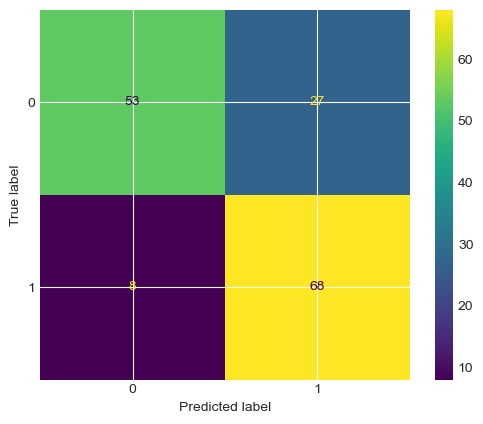

In [75]:
# Convert specific hyperparameters to integers
best_xgb['max_depth'] = int(best_xgb['max_depth'])  
best_xgb['min_child_weight'] = int(best_xgb['min_child_weight'])

# Initialize and train the XGBoost model
model = XGBClassifier(**best_xgb, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
model = model.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

# Compute and display the confusion matrix
matrix = confusion_matrix(y_test, y_pred) 
cm = ConfusionMatrixDisplay(matrix)
cm.plot()  # Display the confusion matrix